# SD211 TP2

In [1]:
import numpy as np
import math
from scipy.optimize import check_grad
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [2]:

def load_diabetic_retinopathy(filename, minidata=False):
    """
    Cette fonction lit le fichier filename, par exemple
    filename = 'diabeticRetinopathy.csv'
    Elle retourne 
    X : une matrice de caracteristiques
    y : un vecteur des classes tel que si y[i] = 1, la tumeur est maligne
        et si y[i] = -1, la tumeur est benigne

    Pour plus d'infos sur la base de donnees,
    http://archive.ics.uci.edu/ml/datasets/Diabetic+Retinopathy+Debrecen+Data+Set
    """

    data = np.loadtxt(filename, delimiter=',')

    y = data[:, -1] * 2 - 1
    X = data[:, :-1]

    # Standardisation de la matrice
    X = X - np.mean(X, axis=0)
    X = X / np.std(X, axis=0)

    return X, y


# 1 Régularisation de Tikhonov

In [3]:
X,y=load_diabetic_retinopathy('diabeticRetinopathy.csv')

In [4]:
X = np.c_[np.ones(X.shape[0]), X]

## Question 1.1
Soit $h_{i}(w,w_{0})=log(1+exp(-y_{i}(x_{i}^{T}w+w_{0})))$, <br>
si on prend $a_i=\begin{bmatrix}-y_{i}x_{i}\\ -y_{i}\end{bmatrix}$, et $z=\begin{bmatrix}w\\ w_{0}\end{bmatrix}$, <br>
alors $h_{i}(w,w_{0})=log(1+exp(<a_i,z>))$ ,<br>
$\nabla h_{i}=\frac{exp(<a_i,z>)}{1+exp(<a_i,z>)}a_i$,<br>
$\nabla ^{2}h_{i}=\frac{exp(<a_i,z>)}{(1+exp(<a_i,z>))^2}a_ia_i^T$,<br>
$\nabla ^{2}h_{i}$ est définie positive car $xa_ia_i^Tx^T=(xa_i)^T(xa_i)=||xa_i||^2 \geq 0$. donc $\nabla ^{2}h_{i}$ est convex.<br>
On prend $g(w,w_{0})=\frac{\rho}{2}||w||^{2}$,<br>
On fait le développement limité de g:$||w+h||^2=||w||^2+2<w,h>+||h||^2=||w||^2+2<w,h>+h^TI_dh$,<br>
Par la définition de gradient et hessien, on trouve
$\nabla g=\rho \begin{bmatrix}w\\ 0\end{bmatrix}$,<br>
$\nabla ^2 g=\rho \begin{bmatrix}I_d & 0\\ 0& 0\end{bmatrix}$,<br>
Pour la même raison, g est convex. Comme $f_1$ est la combinaison linéaire des fonctions convexes, donc $f_{1}$ est convexe.<br>
$\nabla f_{1}=\frac{1}{n}\sum_{i=1}^{n}\frac{exp(<a_i,z>)}{1+exp(<a_i,z>)}a_i+\rho \begin{bmatrix}w\\ 0\end{bmatrix}$<br>
$\nabla ^2 f_{1}=\frac{1}{n}\sum_{i=1}^{n}\frac{exp(<a_i,z>)}{(1+exp(<a_i,z>))^2}a_ia_i^T+\rho \begin{bmatrix}I_d & 0\\0&0\end{bmatrix}$

## Question 1.2

In [5]:
def objective(X,y,z,rho):
    w = z[1:]
    n1,n2 = X.shape
    val=0
    grad=0
    H=0
    for i in range(n1):
        a = -y[i] * X[i,:]
        t = math.exp(a.dot(z))
        val = val+math.log(1+t)
        grad = grad+(t/(1+t))*a
        H = H+(t/(1+t)**2)*a.reshape(-1,1).dot(a.reshape(1,-1))
    
    val = 1./n1*val+rho/2*np.sum(w**2)
    grad = 1./n1*grad+rho*np.r_[0, w]
    M=np.eye(n2)
    M[0][0]=0
    H = 1./n1*H+rho*M
    
    return val,grad,H

utilisation de check_grad 

In [6]:
def func(z):
    w = z[1:]
    n1,n2 = X.shape
    val = 0
    for i in range(n1):
        a = -y[i] * X[i,:]
        t = math.exp(a.dot(z))
        val = val+math.log(1+t)
    val = 1./n1*val+rho/2*np.sum(w**2)
    return val

def gradient(z):
    w = z[1:]
    n1,n2 = X.shape
    grad = 0
    for i in range(n1):
        a = -y[i] * X[i,:]
        t = math.exp(a.dot(z))
        grad = grad+(t/(1+t))*a
    grad = 1./n1*grad+rho*np.r_[0, w]
    return grad

In [7]:
rho = 1./X.shape[0]
z = np.zeros(X.shape[1])
print("la différence de gradient est %f" % check_grad(func,gradient,z))

la différence de gradient est 0.000006


## Question 1.3

In [8]:
def newton(f,X,y,z,rho):
    G=[]
    n1,n2=X.shape
    grad = f(X,y,z,rho)[1]
    H = f(X,y,z,rho)[2]
    norme2 = math.sqrt(np.sum(grad**2))
    G.append(norme2)
    while norme2 > 1e-10:
        H_=np.linalg.solve(H, np.identity(n2))
        z=z-H_.dot(grad)
        grad = f(X,y,z,rho)[1]
        H = f(X,y,z,rho)[2]
        norme2 = math.sqrt(np.sum(grad**2))
        G.append(norme2)
    val = f(X,y,z,rho)[0]
    return val,G

In [9]:
z = np.zeros(X.shape[1])
val, grad_norms= newton(objective,X,y,z,rho)
print "la valeur minimale est %f" %val
print "nombre d'iteration est %d" %(len(grad_norms)-1)

la valeur minimale est 0.530019
nombre d'iteration est 8


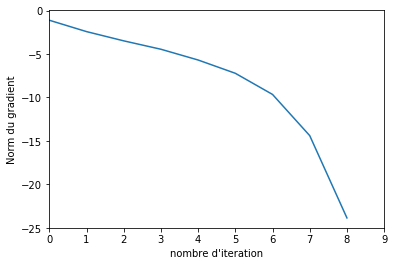

In [10]:
plt.plot(range(0, len(grad_norms)), np.log(grad_norms))
plt.xlabel("nombre d'iteration")
plt.ylabel("Norm du gradient")
plt.xlim(0, len(grad_norms))
plt.show()

## Question 1.4

In [11]:
z = 0.3*np.ones(X.shape[1])
val, grad_norms= newton(objective,X,y,z,rho)
print "la valeur minimale est %f" %val

OverflowError: (34, 'Result too large')

Du coup, on voit que l'algorithme n'est pas convergent.

## Question 1.5

In [12]:
def newton_armijo(func, X, y, z, rho, a, b, beta):
    n1,n2 = X.shape
    val, grad, H = func(X,y,z,rho)
    grad_norm = math.sqrt(np.sum(grad**2))
    norms = [grad_norm]
    d = np.linalg.solve(H, np.identity(n2)).dot(grad)
    gamma = b / 2.
    cnt = 0
    while (grad_norm > 1e-10):
        gamma = 2*gamma
        val_ = func(X , y , z - gamma*d, rho)[0]
        while (val_ > val - beta*gamma*d.dot(grad)):
            gamma = gamma*a
            val_ = func(X , y, z - gamma*d, rho)[0]
        z = z - gamma*d
        val, grad, H = func(X, y, z, rho)
        d = np.linalg.solve(H, np.identity(n2)).dot(grad)
        grad_norm = np.sqrt(np.sum(grad**2))
        norms.append(grad_norm)
        cnt = cnt + 1
    return val, norms,z

La choix classique de recherche linéaire  est a=0.5 et $b=\gamma_{k-1}$. Comme $\gamma$ dans la méthode de Newton originale est 1 par défaut, on prend b=2. Pour $\beta$, on prend 0.5 comme sa valeur et donc on devient à la recherche linéaire de Taylor-Based.

In [13]:
rho = 1./X.shape[0]
a = 0.5
b = 2
beta = 0.5
z = 0.3*np.ones(X.shape[1])
val, norms,z1 = newton_armijo(objective, X, y, z, rho, a, b, beta)
print "la valeur minimale est: %f" % val
print "nombre d'iteration est %d" % (len(norms)-1)
print "les parametres sont:"
print z1

la valeur minimale est: 0.530019
nombre d'iteration est 7
les parametres sont:
[ 0.67731198  0.28526576 -0.24554742  5.61365006  0.9888679  -1.82791918
 -2.55695256 -1.58747255  0.43396361  0.48515529 -0.40441764  0.17280405
 -0.57564945  0.43832626 -0.62435831  1.25356177  0.72621094 -0.00607139
 -0.1490878  -0.09505212]


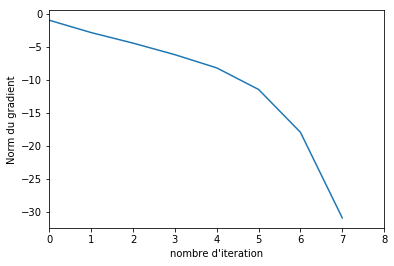

In [14]:
plt.plot(range(0, len(norms)), np.log(norms))
plt.xlabel("nombre d'iteration")
plt.ylabel("Norm du gradient")
plt.xlim(0, len(norms))
plt.show()

# 2 Régularisation pour la parcimonie

## Question 2.1

Parce que  $||\cdot||_1$ n'est pas dérivable.

## Question 2.2

$F_2=f_2+g_2$ où <br>
$f_2(w,w_{0})=\sum_{i=1}^{n}log(1+exp(-y_{i}(x_{i}^{T}w+w_{0})))$, et <br> 
$g_2(w,w_{0})=\rho ||w||_1$ <br>
L'opérateur proximal de $g_2$ est $prox_{\gamma g}(u)=argmin_{y}(\gamma g(y)+\frac{||y-u||^2}{2})$<br>
Dans la Question 1.1, on a prouvé que $f_2$ est convexe. Comme norme 1 est convexe, $g_2$ est convexe donc $F_2$ est convexe.

## Question 2.3

$prox_{\gamma g}(u)=argmin_{y}(\gamma g(y)+\frac{||y-u||^2}{2})=argmin_{y}(\gamma \rho ||y||_1 + \frac{||y-u||^2}{2})$ <br>
$=\sum_{i=1}^n argmin_{y_i}(\gamma \rho |y_i|+\frac{(y_i -u)^2}{2})$<br><br>
Cas 1, $y_i \geq 0$:<br>
$argmin_{y_i}(\gamma \rho |y_i|+\frac{(y_i -u)^2}{2})=argmin_{y_i}(2\gamma \rho y_i+y_i^2+u^2-2y_i u)=argmin_{y_i}((y_i-(u-\gamma \rho))^2)$<br>
si $u-\gamma \rho>0$ i.e $u>\gamma \rho$, $y_i^*=u-\gamma\rho$,<br>
si $u-\gamma \rho<0$ i.e $u<\gamma \rho$, $y_i^*=0$<br><br>
Cas 2, $y_i \leq 0$:<br>
$argmin_{y_i}(\gamma \rho |y_i|+\frac{(y_i -u)^2}{2})=argmin_{y_i}(-2\gamma \rho y_i+y_i^2+u^2-2y_i u)=argmin_{y_i}((y_i-(u+\gamma \rho))^2)$<br>
si $u+\gamma \rho<0$ i.e $u<-\gamma \rho$, $y_i^*=u+\gamma\rho$,<br>
si $u+\gamma \rho>0$ i.e $u>-\gamma \rho$, $y_i^*=0$<br><br>
En conclusion,$y_i^*=\left\{\begin{matrix}
u-\gamma \rho,u>\gamma \rho
\\ u+\gamma \rho,u<-\gamma \rho
\\ 0,-\gamma \rho<u<\gamma \rho
\end{matrix}\right.$<br>
Ensuite, pour chercher $\gamma$, on utilise la recherche linéaire de Taylor.

In [15]:
def f2(z, X, y):
    n1,n2 = X.shape
    val=0
    grad=0
    for i in range(n1):
        a = -y[i] * X[i,:]
        t = math.exp(a.dot(z))
        val = val+math.log(1+t)
        grad = grad+(t/(1+t))*a
    
    val = 1./n1*val
    grad = 1./n1*grad

    return val, grad

def g2(z,rho):
    return rho*np.sum(abs(z))

def prox_min(u, k):
    n = u.shape[0]
    y = np.zeros(n)
    y[0] = u[0]
    for i in range(1,n):
        if u[i]>k:
            y[i] = u[i] - k
        elif u[i]<-k:
            y[i] = u[i] + k
        else:
            pass
    
    return y

def proximal_gradient(f,g, prox_min, z, X, y, rho, a, b, stop):
    val, grad = f(z, X, y)
    gamma = b / 2.
    gap = stop*2
    iteration = 0
    while (gap > stop ):
        gamma = 2*gamma
        z_ = prox_min(z - gamma*grad, gamma*rho)
        val_ = f(z_, X, y)[0]
        while (val_ > val + grad.dot(z_-z) + np.sum((z-z_)**2)/(2*gamma)):
            gamma = gamma*a
            z_ = prox_min(z - gamma*grad, gamma*rho)
            val_ = f(z_, X, y)[0]
        obj = val + rho*np.sum(abs(z[1:]))
        obj_ = val_ + rho*np.sum(abs(z[1:]))
        gap = abs(obj - obj_)
        z = z_
        val, grad = f(z, X, y)
        iteration = iteration + 1
    return obj_ , iteration,z

In [16]:
rho = 0.1
a = 0.5
b = 1
z = 0.3*np.ones(X.shape[1])
val,iteration,z2  = proximal_gradient(f2,g2,prox_min, z, X, y, rho, a, b, 1e-10)
print "la valeur minimale obtenue est: %f" % val
print "nombre d'iteration: %d" % iteration
print "les parametres sont:"
print z2

la valeur minimale obtenue est: 0.686959
nombre d'iteration: 11
les parametres sont:
[ 0.12499102  0.          0.          0.18733049  0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]


# 3 Comparaison

## Question 3.1

1.La fonction objective de la régularisation de Tikhonov est différentiable, mais celle de la régularisation  pour la parcimonie n'est pas différentiable. Ils sont tout convexes.
<br><br>
2.Selon les paramètres w,w0 obtenus, la régularisation de Tikhonov utilise tout les paramètres, mais la régularisation  pour la parcimonie utilise seulement deux paramètres. 

## Question 3.2

On calcule la précision de cette deux méthode.

In [17]:
def proba(x,y,z):
    t = math.exp(-(z.dot(x)))
    if y == 1:
        return 1./(1+t)
    else:
        return 1-1./(1+t)

In [18]:
n = X.shape[0]
correct_count1 = 0
correct_count2 = 0
for i in range(n):
    p1 = proba(X[i,:],y[i],z1)
    p2 = proba(X[i,:],y[i],z2)
    if p1>0.5:
        correct_count1 = correct_count1 + 1
    if p2>0.5:
        correct_count2 = correct_count2 + 1

precision1 = 1.*correct_count1/n
precision2 = 1.*correct_count2/n
print "la precision de la regularisation de Tikhonov:  %f" % precision1 
print "la precision de la regularisation de pour la parcimonie: %f" % precision2

la precision de la regularisation de Tikhonov:  0.741095
la precision de la regularisation de pour la parcimonie: 0.609904


On peut conclure que la regularisation de Tikhonov a une meilleure performance.

In [22]:
pred_y1 = np.sign(X.dot(z1))
pred_y2 = np.sign(X.dot(z2))
print ("Newton + recherche lineaire:\n")
print (classification_report(y, pred_y1))
print ("Gradient proximal + recherche lineaire:\n")
print (classification_report(y, pred_y2))

Newton + recherche lineaire:

             precision    recall  f1-score   support

       -1.0       0.69      0.82      0.75       540
        1.0       0.81      0.67      0.73       611

avg / total       0.75      0.74      0.74      1151

Gradient proximal + recherche lineaire:

             precision    recall  f1-score   support

       -1.0       0.61      0.46      0.52       540
        1.0       0.61      0.75      0.67       611

avg / total       0.61      0.61      0.60      1151

